# Cat breeds model training notebook

Исходные данные размещены на Kaggle (размеченные фотографии 67 пород кошек):
https://www.kaggle.com/ma7555/cat-breeds-dataset

Данные загружаются с Google Drive, для этого необходимо его смонтировать
загрузку файла по прямой ссылке без монтирования не удалось реализовать, т.к.
Google Drive при загрузке большого файла открывает страницу с предупреждением
про проверку антивирусом

для воспроизведения обучения модели необходимо файл с данными Archive.zip
разместить на Google Drive в папке data (или поменять код в следующей ячейке,
если расположение файла другое) 

Модель тренируется по механизму Transfer Learning (используется модель Big Transfer в качестве body, head модели меняется для настройки на 67 классов)

Натренированная модель сохраняется на Google Drive в папку data в файл cats_model_state


In [2]:
from google.colab import drive
import pandas as pd
import os
import glob
from functools import partial
from collections import OrderedDict

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, Subset, DataLoader

import torchvision as tv

import requests

import io as io_

from skimage import io

import PIL

from sklearn.model_selection import train_test_split
import pickle


In [3]:
drive.mount('/content/gdrive')
!mkdir /content/cats/
!unzip -q /content/gdrive/MyDrive/data/Archive.zip -d /content/cats/

Mounted at /content/gdrive


In [4]:
preprocess_train = tv.transforms.Compose([
    tv.transforms.ToPILImage(mode='RGB'),
    tv.transforms.Resize(size=128, interpolation=PIL.Image.BILINEAR),  # It's the default, just being explicit for the reader.
    tv.transforms.CenterCrop((128, 128)),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Get data into [-1, 1]
])

preprocess_eval = tv.transforms.Compose([
    tv.transforms.Resize((128, 128), interpolation=PIL.Image.BILINEAR),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# now we need to define custom dataset for the downloaded data

class CatBreed(Dataset):
  def __init__ (self,csv_file,root_dir,transform=None):
    self.annotations=pd.read_csv(csv_file)
    self.class_names=list(self.annotations['breed'].unique())
    self.annotations['class']=self.annotations.apply(lambda x: self.class_names.index(x['breed']), axis=1)
    self.root_dir=root_dir
    self.transform=transform
    # deleting entries which does not have proper images (otherwise the training process will break)
    def check_color_mode(x):    
      try:
          img_path=glob.glob(os.path.join(self.root_dir,'images',x['breed']+'/'+str(x['id'])+'*.jpg'))[0]
          image=io.imread(img_path)
          if self.transform:
            image=self.transform(image)
      except:
          return False
      return True
    self.annotations['image_ok']=self.annotations.apply(check_color_mode,axis=1)
    self.annotations=self.annotations[self.annotations['image_ok']].reset_index(drop=True)

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self,index):
    img_path=glob.glob(os.path.join(self.root_dir,'images',self.annotations.loc[index,'breed']+'/'+str(self.annotations.loc[index,'id'])+'*.jpg'))[0]
    try:
      image=io.imread(img_path)
    except:
      raise Exception('Image not loaded: '+img_path)
    y_label=int(self.annotations.loc[index,'class'])
    if self.transform:
      image=self.transform(image)
    return (image,y_label)
  

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [5]:
dataset=CatBreed('/content/cats/data/cats.csv','/content/cats',transform=preprocess_train)
train_len=int(len(dataset)*0.8)
test_len=len(dataset)-train_len

SEED=42
train_idx, test_idx, = train_test_split(
    range(len(dataset)),
    test_size=test_len,
    random_state=SEED
)

trainset=Subset(dataset, train_idx)
testset=Subset(dataset, test_idx)


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
def get_weights(bit_variant):
  response = requests.get(f'https://storage.googleapis.com/bit_models/{bit_variant}.npz')
  response.raise_for_status()
  return np.load(io_.BytesIO(response.content))

In [8]:
weights = get_weights('BiT-M-R50x1')  # You could use other variants, such as R101x3 or R152x4 here, but it is not advisable in a colab.

In [9]:
class StdConv2d(nn.Conv2d):
  def forward(self, x):
    w = self.weight
    v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
    w = (w - m) / torch.sqrt(v + 1e-10)
    return F.conv2d(x, w, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [10]:
def conv3x3(cin, cout, stride=1, groups=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=3, stride=stride, padding=1, bias=bias, groups=groups)

def conv1x1(cin, cout, stride=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=1, stride=stride, padding=0, bias=bias)

In [11]:
def tf2th(conv_weights):
  """Possibly convert HWIO to OIHW"""
  if conv_weights.ndim == 4:
    conv_weights = np.transpose(conv_weights, [3, 2, 0, 1])
  return torch.from_numpy(conv_weights)

In [12]:
def tf2th(conv_weights):
  """Possibly convert HWIO to OIHW"""
  if conv_weights.ndim == 4:
    conv_weights = np.transpose(conv_weights, [3, 2, 0, 1])
  return torch.from_numpy(conv_weights)

In [13]:
class PreActBottleneck(nn.Module):
  """
  Follows the implementation of "Identity Mappings in Deep Residual Networks" here:
  https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua

  Except it puts the stride on 3x3 conv when available.
  """
  def __init__(self, cin, cout=None, cmid=None, stride=1):
    super().__init__()
    cout = cout or cin
    cmid = cmid or cout//4

    self.gn1 = nn.GroupNorm(32, cin)
    self.conv1 = conv1x1(cin, cmid)
    self.gn2 = nn.GroupNorm(32, cmid)
    self.conv2 = conv3x3(cmid, cmid, stride)  # Original ResNetv2 has it on conv1!!
    self.gn3 = nn.GroupNorm(32, cmid)
    self.conv3 = conv1x1(cmid, cout)
    self.relu = nn.ReLU(inplace=True)

    if (stride != 1 or cin != cout):
      # Projection also with pre-activation according to paper.
      self.downsample = conv1x1(cin, cout, stride)

  def forward(self, x):
      # Conv'ed branch
      out = self.relu(self.gn1(x))

      # Residual branch
      residual = x
      if hasattr(self, 'downsample'):
          residual = self.downsample(out)

      # The first block has already applied pre-act before splitting, see Appendix.
      out = self.conv1(out)
      out = self.conv2(self.relu(self.gn2(out)))
      out = self.conv3(self.relu(self.gn3(out)))

      return out + residual

  def load_from(self, weights, prefix=''):
    with torch.no_grad():
      self.conv1.weight.copy_(tf2th(weights[prefix + 'a/standardized_conv2d/kernel']))
      self.conv2.weight.copy_(tf2th(weights[prefix + 'b/standardized_conv2d/kernel']))
      self.conv3.weight.copy_(tf2th(weights[prefix + 'c/standardized_conv2d/kernel']))
      self.gn1.weight.copy_(tf2th(weights[prefix + 'a/group_norm/gamma']))
      self.gn2.weight.copy_(tf2th(weights[prefix + 'b/group_norm/gamma']))
      self.gn3.weight.copy_(tf2th(weights[prefix + 'c/group_norm/gamma']))
      self.gn1.bias.copy_(tf2th(weights[prefix + 'a/group_norm/beta']))
      self.gn2.bias.copy_(tf2th(weights[prefix + 'b/group_norm/beta']))
      self.gn3.bias.copy_(tf2th(weights[prefix + 'c/group_norm/beta']))
      if hasattr(self, 'downsample'):
        self.downsample.weight.copy_(tf2th(weights[prefix + 'a/proj/standardized_conv2d/kernel']))
    return self

In [14]:
class ResNetV2(nn.Module):
  BLOCK_UNITS = {
      'r50': [3, 4, 6, 3],
      'r101': [3, 4, 23, 3],
      'r152': [3, 8, 36, 3],
  }

  def __init__(self, block_units, width_factor, head_size=21843, zero_head=False):
    super().__init__()
    wf = width_factor  # shortcut 'cause we'll use it a lot.

    self.root = nn.Sequential(OrderedDict([
        ('conv', StdConv2d(3, 64*wf, kernel_size=7, stride=2, padding=3, bias=False)),
        ('padp', nn.ConstantPad2d(1, 0)),
        ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0)),
        # The following is subtly not the same!
        #('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
    ]))

    self.body = nn.Sequential(OrderedDict([
        ('block1', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin= 64*wf, cout=256*wf, cmid=64*wf))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=256*wf, cout=256*wf, cmid=64*wf)) for i in range(2, block_units[0] + 1)],
        ))),
        ('block2', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=256*wf, cout=512*wf, cmid=128*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=512*wf, cout=512*wf, cmid=128*wf)) for i in range(2, block_units[1] + 1)],
        ))),
        ('block3', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin= 512*wf, cout=1024*wf, cmid=256*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=1024*wf, cout=1024*wf, cmid=256*wf)) for i in range(2, block_units[2] + 1)],
        ))),
        ('block4', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=1024*wf, cout=2048*wf, cmid=512*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=2048*wf, cout=2048*wf, cmid=512*wf)) for i in range(2, block_units[3] + 1)],
        ))),
    ]))

    self.zero_head = zero_head
    self.head = nn.Sequential(OrderedDict([
        ('gn', nn.GroupNorm(32, 2048*wf)),
        ('relu', nn.ReLU(inplace=True)),
        ('avg', nn.AdaptiveAvgPool2d(output_size=1)),
        ('conv', nn.Conv2d(2048*wf, head_size, kernel_size=1, bias=True)),
    ]))
  
  def forward(self, x):
    x = self.head(self.body(self.root(x)))
    assert x.shape[-2:] == (1, 1)  # We should have no spatial shape left.
    return x[...,0,0]

  def load_from(self, weights, prefix='resnet/'):
    with torch.no_grad():
      self.root.conv.weight.copy_(tf2th(weights[f'{prefix}root_block/standardized_conv2d/kernel']))
      self.head.gn.weight.copy_(tf2th(weights[f'{prefix}group_norm/gamma']))
      self.head.gn.bias.copy_(tf2th(weights[f'{prefix}group_norm/beta']))
      if self.zero_head:
        nn.init.zeros_(self.head.conv.weight)
        nn.init.zeros_(self.head.conv.bias)
      else:
        self.head.conv.weight.copy_(tf2th(weights[f'{prefix}head/conv2d/kernel']))
        self.head.conv.bias.copy_(tf2th(weights[f'{prefix}head/conv2d/bias']))

      for bname, block in self.body.named_children():
        for uname, unit in block.named_children():
          unit.load_from(weights, prefix=f'{prefix}{bname}/{uname}/')
    return self

In [15]:
%config InlineBackend.figure_format = 'retina'

In [16]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [17]:
def stairs(s, v, *svs):
    """ Implements a typical "stairs" schedule for learning-rates.
    Best explained by example:
    stairs(s, 0.1, 10, 0.01, 20, 0.001)
    will return 0.1 if s<10, 0.01 if 10<=s<20, and 0.001 if 20<=s
    """
    for s0, v0 in zip(svs[::2], svs[1::2]):
        if s < s0:
            break
        v = v0
    return v

def rampup(s, peak_s, peak_lr):
  if s < peak_s:  # Warmup
    return s/peak_s * peak_lr
  else:
    return peak_lr

def schedule(s):
  step_lr = stairs(s, 3e-3, 200, 3e-4, 300, 3e-5, 400, 3e-6, 500, None)
  return rampup(s, 100, step_lr)

In [18]:
model = ResNetV2(ResNetV2.BLOCK_UNITS['r50'], width_factor=1, head_size=67, zero_head=True)
model.load_from(weights)
model.to(device);

In [19]:
sampler = torch.utils.data.RandomSampler(trainset, replacement=True, num_samples=256)
loader_train = torch.utils.data.DataLoader(trainset, batch_size=256, num_workers=2, sampler=sampler)
loader_test = torch.utils.data.DataLoader(testset, batch_size=256, num_workers=2, sampler=sampler)

In [20]:
crit = nn.CrossEntropyLoss()
opti = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
#model.train();

In [21]:
def eval_cats(model, bs=100, progressbar=True):
  loader_test = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=2)

  model.eval()

  if progressbar is True:
    progressbar = display(progress(0, len(loader_test)), display_id=True)

  preds = []
  with torch.no_grad():
    for i, (x, t) in enumerate(loader_test):
      x, t = x.to(device), t.numpy()
      logits = model(x)
      _, y = torch.max(logits.data, 1)
      preds.extend(y.cpu().numpy() == t)
      progressbar.update(progress(i+1, len(loader_test)))

  return np.mean(preds)

In [22]:
S = 500
def schedule(s):
  step_lr = stairs(s, 3e-3, 200, 3e-4, 300, 3e-5, 400, 3e-6, S, None)
  return rampup(s, 100, step_lr)

pb_train = display(progress(0, S), display_id=True)
pb_test = display(progress(0, 100), display_id=True)
losses = [[]]
accus_train = [[]]
accus_test = []

steps_per_iter = 512 // loader_train.batch_size

while len(losses) < S:
  for x, t in loader_train:
    x, t = x.to(device), t.to(device)

    logits = model(x)
    loss = crit(logits, t) / steps_per_iter
    loss.backward()
    losses[-1].append(loss.item())

    with torch.no_grad():
      accus_train[-1].extend(torch.max(logits, dim=1)[1].cpu().numpy() == t.cpu().numpy())

    if len(losses[-1]) == steps_per_iter:
      losses[-1] = sum(losses[-1])
      losses.append([])
      accus_train[-1] = np.mean(accus_train[-1])
      accus_train.append([])

      # Update learning-rate according to schedule, and stop if necessary
      lr = schedule(len(losses) - 1)
      for param_group in opti.param_groups:
        param_group['lr'] = lr

      opti.step()
      opti.zero_grad()

      pb_train.update(progress(len(losses) - 1, S))
      print(f'\r[Step {len(losses) - 1}] loss={losses[-2]:.2e} '
            f'train accu={accus_train[-2]:.2%} '
            f'test accu={accus_test[-1] if accus_test else 0:.2%} '
            f'(lr={lr:g})', end='', flush=True)

      if len(losses) % 25 == 0:
        accus_test.append(eval_cats(model, progressbar=pb_test))
        model.train()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[Step 499] loss=1.71e+00 train accu=49.41% test accu=42.00% (lr=3e-06)

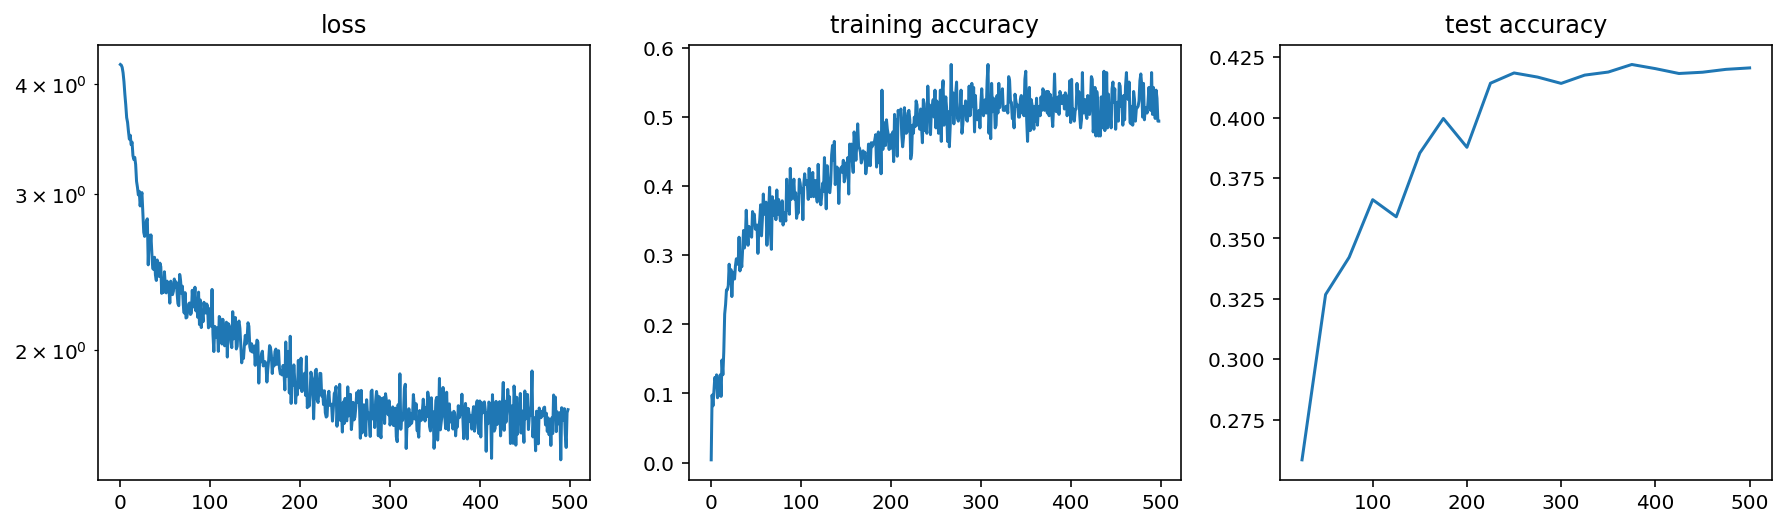

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.plot(losses[:-1])
ax1.set_yscale('log')
ax1.set_title('loss')
ax2.plot(accus_train[:-1])
ax2.set_title('training accuracy')
ax3.plot(np.arange(25, 501, 25), accus_test)
ax3.set_title('test accuracy');

In [24]:
#drive.mount('/content/gdrive')
torch.save(model.state_dict(),'/content/gdrive/MyDrive/data/cats_model_state')
with open('/content/gdrive/MyDrive/data/cat_model_class_names', 'wb') as f:
  pickle.dump(dataset.class_names, f)
drive.flush_and_unmount()